In [88]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import pacf
from statsmodels.regression.linear_model import yule_walker
#from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from sklearn.metrics import mean_squared_error
from math import sqrt

from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import pacf
from statsmodels.regression.linear_model import yule_walker
#from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [89]:
# Generate the data
# import numpy as np
# ar = np.array([1, -0.8, 0.2])
# ma = np.array([1])
# my_simulation = ArmaProcess(ar, ma).generate_sample(nsample=100)

# print(ar, ma, my_simulation)

# plt.figure(figsize=[10, 5]); # Set dimensions for figure
# plt.plot(my_simulation, linestyle='-', marker='o', color='b')
# plt.title("Simulated Process")
# plt.show()

In [90]:
# import warnings
# import statsmodels.api as sm
# from statsmodels.tsa.arima_model import ARMA

# mod = sm.tsa.arima.ARIMA(my_simulation, order=(2, 0, 0))
# mod_fit = mod.fit()
# print(mod_fit.summary())

In [91]:
import pandas as pd
import yfinance as yf
AMZN = yf.download('BTC-USD', 
                      start='2015-01-01', 
                      end='2022-03-26', 
                      progress=False)
# AMZN = yf.download('AMZN') for all 
all_data = AMZN[['Adj Close','Open', 'High', 'Low', 'Close', 'Volume']].round(2)
all_data

,Adj Close,Open,High,Low,Close,Volume
Date,,,,,,
2015-01-01,314.25,320.43,320.43,314.00,314.25,8036550
2015-01-02,315.03,314.08,315.84,313.57,315.03,7860650
2015-01-03,281.08,314.85,315.15,281.08,281.08,33054400
2015-01-04,264.20,281.15,287.23,257.61,264.20,55629100
2015-01-05,274.47,265.08,278.34,265.08,274.47,43962800
...,...,...,...,...,...,...
2022-03-22,42358.81,41074.11,43124.71,40948.28,42358.81,32004652376
2022-03-23,42892.96,42364.38,42893.51,41877.51,42892.96,25242943069
2022-03-24,43960.93,42886.65,44131.86,42726.16,43960.93,31042992291


<AxesSubplot:xlabel='Date'>

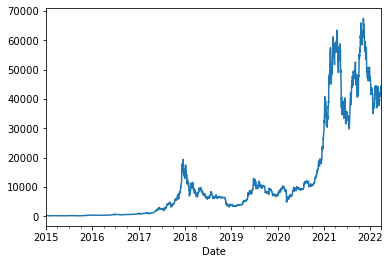

In [92]:
all_data['Adj Close'].plot()

In [93]:
print("There are "+ str(all_data[:'2020'].shape[0]) + " observations in the training data")
print("There are "+ str(all_data['2021':].shape[0]) + " observations in the test data")

There are 2192 observations in the training data
There are 450 observations in the test data


In [94]:
def ts_train_test(all_data,time_steps,for_periods):
    '''
    input: 
      data: dataframe with dates and price data
    output:
      X_train, y_train: data from 2015/01/01 - 2020
      X_test:  data from 2021 - 2022/03/26
      sc:      insantiated MinMaxScaler object fit to the training data
    '''
    # create training and test set
    ts_train = all_data[:'2020'].iloc[:,0:1].values
    ts_test  = all_data['2021':].iloc[:,0:1].values
    ts_train_len = len(ts_train)
    ts_test_len = len(ts_test)

    # create training data of s samples and t time steps
    X_train = []
    y_train = []
    y_train_stacked = []
    for i in range(time_steps,ts_train_len-1): 
        X_train.append(ts_train[i-time_steps:i,0])
        y_train.append(ts_train[i:i+for_periods,0])
    X_train, y_train = np.array(X_train), np.array(y_train)

    # Reshaping X_train for efficient modelling
    X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

    inputs = pd.concat((all_data["Adj Close"][:'2020'], all_data["Adj Close"]['2021':]),axis=0).values
    inputs = inputs[len(inputs)-len(ts_test) - time_steps:]
    inputs = inputs.reshape(-1,1)

    # Preparing X_test
    X_test = []
    for i in range(time_steps,ts_test_len+time_steps-for_periods):
        X_test.append(inputs[i-time_steps:i,0])
        
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

    return X_train, y_train , X_test

X_train, y_train, X_test = ts_train_test(all_data,5,2)
X_train.shape[0],X_train.shape[1]

(2186, 5)

In [95]:
print(X_train[:2])
print(y_train[:2])

[[[314.25]
  [315.03]
  [281.08]
  [264.2 ]
  [274.47]]

 [[315.03]
  [281.08]
  [264.2 ]
  [274.47]
  [286.19]]]
[[286.19 294.34]
 [294.34 283.35]]


In [96]:
# Convert the 3-D shape of X_train to a data frame so we can see: 
X_train_see = pd.DataFrame(np.reshape(X_train, (X_train.shape[0],X_train.shape[1])))
y_train_see = pd.DataFrame(y_train)
Xy_train_see = pd.concat([X_train_see,y_train_see],axis=1)

# Convert the 3-D shape of X_test to a data frame so we can see: 
X_test_see = pd.DataFrame(np.reshape(X_test, (X_test.shape[0],X_test.shape[1])))
pd.DataFrame(X_test_see)

print("There are " + str(X_train.shape[0]) + " samples in the training data")
print("There are " + str(X_test.shape[0]) + " samples in the test data")

There are 2186 samples in the training data
There are 448 samples in the test data


In [97]:
Xy_train_see

,0,1,2,3,4,0,1
0,314.25,315.03,281.08,264.20,274.47,286.19,294.34
1,315.03,281.08,264.20,274.47,286.19,294.34,283.35
2,281.08,264.20,274.47,286.19,294.34,283.35,290.41
3,264.20,274.47,286.19,294.34,283.35,290.41,274.80
4,274.47,286.19,294.34,283.35,290.41,274.80,265.66
...,...,...,...,...,...,...,...
2181,22803.08,23783.03,23241.35,23735.95,24664.79,26437.04,26272.29
2182,23783.03,23241.35,23735.95,24664.79,26437.04,26272.29,27084.81
2183,23241.35,23735.95,24664.79,26437.04,26272.29,27084.81,27362.44
2184,23735.95,24664.79,26437.04,26272.29,27084.81,27362.44,28840.95


# All code below based on models explained in https://medium.com/swlh/a-technical-guide-on-rnn-lstm-gru-for-stock-price-prediction-bce2f7f30346

# Build simple RNN

- this works very poorly without regularization

rmse:  7933.992865594099


(62948252.0, <AxesSubplot:xlabel='Date'>)

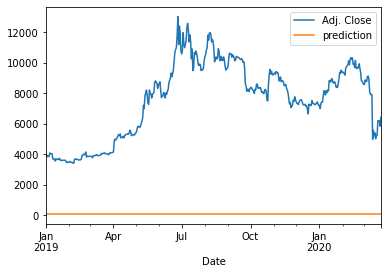

In [98]:
def simple_rnn_model(X_train, y_train, X_test):
    '''
    create single layer rnn model trained on X_train and y_train
    and make predictions on the X_test data
    '''
    # create a model
    from keras.models import Sequential
    from keras.layers import Dense, SimpleRNN
    
    my_rnn_model = Sequential()
    my_rnn_model.add(SimpleRNN(32, return_sequences=True))
    #my_rnn_model.add(SimpleRNN(32, return_sequences=True))
    #my_rnn_model.add(SimpleRNN(32, return_sequences=True))
    my_rnn_model.add(SimpleRNN(32))
    my_rnn_model.add(Dense(2)) # The time step of the output

    my_rnn_model.compile(optimizer='rmsprop', loss='mean_squared_error')

    # fit the RNN model
    my_rnn_model.fit(X_train, y_train, epochs=100, batch_size=150, verbose=0)

    # Finalizing predictions
    rnn_predictions = my_rnn_model.predict(X_test)

    return my_rnn_model, rnn_predictions

my_rnn_model, rnn_predictions = simple_rnn_model(X_train, y_train, X_test)
rnn_predictions[1:10]

def actual_pred_plot(preds):
    '''
    Plot the actual vs. prediction
    '''
    actual_pred = pd.DataFrame(columns = ['Adj. Close', 'prediction'])
    actual_pred['Adj. Close'] = all_data.loc['2019':,'Adj Close'][0:len(preds)]
    actual_pred['prediction'] = preds[:,0]

    from keras.metrics import MeanSquaredError
    m = MeanSquaredError()
    m.update_state(np.array(actual_pred['Adj. Close']),np.array(actual_pred['prediction']))
    
    
    rmse=sqrt(mean_squared_error(actual_pred['Adj. Close'],actual_pred['prediction']))

    print('rmse: ', rmse)
    
    
    return (m.result().numpy(), actual_pred.plot() )
    
actual_pred_plot(rnn_predictions) 

In [99]:
# this function first performs normalization to data and then separates train/test split

def ts_train_test_normalize(all_data,time_steps,for_periods):
    '''
    input: 
      data: dataframe with dates and price data
    output:
      X_train, y_train: data from 2013/1/1-2018/12/31
      X_test:  data from 2019 -
      sc:      insantiated MinMaxScaler object fit to the training data
    '''
    # create training and test set
    ts_train = all_data[:'2018'].iloc[:,0:1].values
    ts_test  = all_data['2019':].iloc[:,0:1].values
    ts_train_len = len(ts_train)
    ts_test_len = len(ts_test)

    # scale the data
    from sklearn.preprocessing import MinMaxScaler
    sc = MinMaxScaler(feature_range=(0,1))
    ts_train_scaled = sc.fit_transform(ts_train)

    # create training data of s samples and t time steps
    X_train = []
    y_train = []
    y_train_stacked = []
    for i in range(time_steps,ts_train_len-1): 
        X_train.append(ts_train_scaled[i-time_steps:i,0])
        y_train.append(ts_train_scaled[i:i+for_periods,0])
    X_train, y_train = np.array(X_train), np.array(y_train)

    # Reshaping X_train for efficient modelling
    X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

    inputs = pd.concat((all_data["Adj Close"][:'2018'], all_data["Adj Close"]['2019':]),axis=0).values
    inputs = inputs[len(inputs)-len(ts_test) - time_steps:]
    inputs = inputs.reshape(-1,1)
    inputs  = sc.transform(inputs)

    # Preparing X_test
    X_test = []
    for i in range(time_steps,ts_test_len+time_steps-for_periods):
        X_test.append(inputs[i-time_steps:i,0])
        
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

    return X_train, y_train , X_test, sc

rmse:  6483.749955963493
CPU times: user 6.71 s, sys: 1.77 s, total: 8.48 s
Wall time: 4.21 s


(42039010.0, <AxesSubplot:xlabel='Date'>)

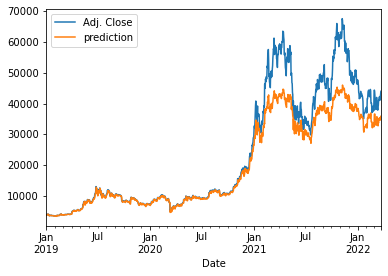

In [100]:
# the same simple rnn model is built using normalized train/test split data

%%time
def simple_rnn_model(X_train, y_train, X_test, sc):
    '''
    create single layer rnn model trained on X_train and y_train
    and make predictions on the X_test data
    '''
    # create a model
    from keras.models import Sequential
    from keras.layers import Dense, SimpleRNN
    
    my_rnn_model = Sequential()
    my_rnn_model.add(SimpleRNN(32, return_sequences=True))
    #my_rnn_model.add(SimpleRNN(32, return_sequences=True))
    #my_rnn_model.add(SimpleRNN(32, return_sequences=True))
    my_rnn_model.add(SimpleRNN(32))
    my_rnn_model.add(Dense(2)) # The time step of the output

    my_rnn_model.compile(optimizer='rmsprop', loss='mean_squared_error')

    # fit the RNN model
    my_rnn_model.fit(X_train, y_train, epochs=100, batch_size=150, verbose=0)

    # Finalizing predictions
    rnn_predictions = my_rnn_model.predict(X_test)
    from sklearn.preprocessing import MinMaxScaler
    rnn_predictions = sc.inverse_transform(rnn_predictions)

    return my_rnn_model, rnn_predictions


X_train, y_train, X_test, sc = ts_train_test_normalize(all_data,7,2)
my_rnn_model, rnn_predictions_2 = simple_rnn_model(X_train, y_train, X_test, sc)
rnn_predictions_2[1:10]
actual_pred_plot(rnn_predictions_2)

rmse:  8126.211371224061
CPU times: user 9.83 s, sys: 1.65 s, total: 11.5 s
Wall time: 5.67 s


(66035308.0, <AxesSubplot:xlabel='Date'>)

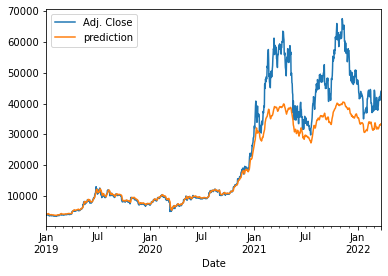

In [101]:
# the same data is used with GRU architecture instead of simple rnn
%%time

def GRU_model(X_train, y_train, X_test, sc):
    # create a model
    from keras.models import Sequential
    from keras.layers import Dense, SimpleRNN, GRU
    from tensorflow.keras.optimizers import SGD
    
    # The GRU architecture
    my_GRU_model = Sequential()
    # First GRU layer with Dropout regularisation
    my_GRU_model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    #my_GRU_model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    #my_GRU_model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    my_GRU_model.add(GRU(units=50, activation='tanh'))
    my_GRU_model.add(Dense(units=2))

    # Compiling the RNN
    my_GRU_model.compile(optimizer=SGD(learning_rate=0.5, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
    # Fitting to the training set
    my_GRU_model.fit(X_train,y_train,epochs=50,batch_size=150, verbose=0)

    GRU_prediction = my_GRU_model.predict(X_test)
    GRU_prediction = sc.inverse_transform(GRU_prediction)

    return my_GRU_model, GRU_prediction

my_GRU_model, GRU_prediction = GRU_model(X_train, y_train, X_test, sc)
GRU_prediction[1:10]
actual_pred_plot(GRU_prediction)

/Users/jonathanlifferth/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


rmse:  8805.248302074771
CPU times: user 22.6 s, sys: 4.82 s, total: 27.4 s
Wall time: 13.2 s


(77532390.0, <AxesSubplot:xlabel='Date'>)

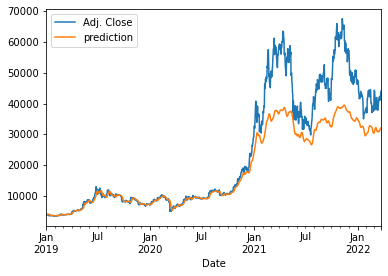

In [102]:
# the same data is used with regularized GRU instead of simple rnn

%%time

def GRU_model_regularization(X_train, y_train, X_test, sc):
    '''
    create GRU model trained on X_train and y_train
    and make predictions on the X_test data
    '''
    # create a model
    from keras.models import Sequential
    from keras.layers import Dense, SimpleRNN, GRU
    from tensorflow.keras.optimizers import SGD
    from keras.layers import Dropout
    
    # The GRU architecture
    my_GRU_model = Sequential()
    # First GRU layer with Dropout regularisation
    my_GRU_model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    my_GRU_model.add(Dropout(0.2))
    # Second GRU layer
    my_GRU_model.add(GRU(units=50, return_sequences=True, activation='tanh'))
    my_GRU_model.add(Dropout(0.2))
    
    # Third GRU layer
    my_GRU_model.add(GRU(units=50, return_sequences=True, activation='tanh'))
    my_GRU_model.add(Dropout(0.2))
    # Fourth GRU layer
    my_GRU_model.add(GRU(units=50, activation='tanh'))
    my_GRU_model.add(Dropout(0.2))
    # The output layer
    my_GRU_model.add(Dense(units=2))
    # Compiling the RNN
    my_GRU_model.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
    # Fitting to the training set
    my_GRU_model.fit(X_train,y_train,epochs=50,batch_size=150, verbose=0)

    GRU_predictions = my_GRU_model.predict(X_test)
    GRU_predictions = sc.inverse_transform(GRU_predictions)

    return my_GRU_model, GRU_predictions

my_GRU_model, GRU_prediction = GRU_model_regularization(X_train, y_train, X_test, sc)
GRU_prediction[1:10]
actual_pred_plot(GRU_prediction)  


# Build GRU including Pytrend data

In [103]:
BTC = yf.download('BTC-USD', 
                      start='2015-01-01', 
                      end='2022-03-26', 
                      progress=False)
# AMZN = yf.download('AMZN') for all 
all_BTC_data = BTC[['Adj Close','Open', 'High', 'Low', 'Close', 'Volume']].round(2)
all_BTC_data

,Adj Close,Open,High,Low,Close,Volume
Date,,,,,,
2015-01-01,314.25,320.43,320.43,314.00,314.25,8036550
2015-01-02,315.03,314.08,315.84,313.57,315.03,7860650
2015-01-03,281.08,314.85,315.15,281.08,281.08,33054400
2015-01-04,264.20,281.15,287.23,257.61,264.20,55629100
2015-01-05,274.47,265.08,278.34,265.08,274.47,43962800
...,...,...,...,...,...,...
2022-03-22,42358.81,41074.11,43124.71,40948.28,42358.81,32004652376
2022-03-23,42892.96,42364.38,42893.51,41877.51,42892.96,25242943069
2022-03-24,43960.93,42886.65,44131.86,42726.16,43960.93,31042992291


In [104]:
import pytrends
import seaborn as sns
from pytrends.request import TrendReq
pytrend = TrendReq()

In [105]:
btc_codes = pytrend.suggestions(keyword='Bitcoin')

In [106]:
btc_codes_df = pd.DataFrame(btc_codes)
btc_codes_df

,mid,title,type
0,/m/05p0rrx,Bitcoin,Currency
1,/g/11gdq16zww,Bitcoin.com,Company
2,/m/0y4vk1r,Kraken,Company
3,/g/11d_wtvc5k,Bitcoin Cash,Cryptocurrency
4,/g/11gxssjj8h,Bitcoin SV,Topic


In [107]:
EXACT_KEYWORDS=btc_codes_df['mid'][0]
DATE_INTERVAL='2015-01-01 2022-03-26'
COUNTRY=["US"] #Use this link for iso country code
CATEGORY=0 # Use this link to select categories
SEARCH_TYPE='' #default is 'web searches',others include 'images','news','youtube','froogle' (google shopping)

In [108]:
EXACT_KEYWORDS

'/m/05p0rrx'

In [109]:
# %%time
# pytrend.build_payload(kw_list=['/m/05p0rrx'], 
#                               timeframe = '2015-01-01 2022-03-26', 
#                               geo = ["US"], 
#                               cat=0,
#                               gprop='') 
# btc_trend = pytrend.interest_over_time()

In [110]:
# btc_trend

In [111]:
%%time
Individual_EXACT_KEYWORD = list(zip(*[iter(EXACT_KEYWORDS)]*1))
print(Individual_EXACT_KEYWORD)
Individual_EXACT_KEYWORD = [list(x) for x in Individual_EXACT_KEYWORD]
print(Individual_EXACT_KEYWORD)
Individual_EXACT_KEYWORD = EXACT_KEYWORDS
print(Individual_EXACT_KEYWORD)
dicti = {}
i = 1
for Country in COUNTRY:
    print(Country)
    for keyword in Individual_EXACT_KEYWORD:
        print(keyword)
        print(DATE_INTERVAL)
        print(Country)
        print(CATEGORY)
        print(SEARCH_TYPE)
        pytrend.build_payload(kw_list=keyword, 
                              timeframe = DATE_INTERVAL, 
                              geo = Country, 
                              cat=CATEGORY,
                              gprop=SEARCH_TYPE) 
        dicti[i] = pytrend.interest_over_time()
        i+=1
        print(dicti)
df_trends = pd.concat(dicti, axis=1)

[('/',), ('m',), ('/',), ('0',), ('5',), ('p',), ('0',), ('r',), ('r',), ('x',)]
[['/'], ['m'], ['/'], ['0'], ['5'], ['p'], ['0'], ['r'], ['r'], ['x']]
/m/05p0rrx
US
/
2015-01-01 2022-03-26
US
0

{1:              /  isPartial
date                     
2015-01-01  93      False
2015-02-01  93      False
2015-03-01  93      False
2015-04-01  92      False
2015-05-01  92      False
...         ..        ...
2021-11-01  88      False
2021-12-01  78      False
2022-01-01  83      False
2022-02-01  85      False
2022-03-01  86      False

[87 rows x 2 columns]}
m
2015-01-01 2022-03-26
US
0

{1:              /  isPartial
date                     
2015-01-01  93      False
2015-02-01  93      False
2015-03-01  93      False
2015-04-01  92      False
2015-05-01  92      False
...         ..        ...
2021-11-01  88      False
2021-12-01  78      False
2022-01-01  83      False
2022-02-01  85      False
2022-03-01  86      False

[87 rows x 2 columns], 2:              m  isPartial
date         

{1:              /  isPartial
date                     
2015-01-01  93      False
2015-02-01  93      False
2015-03-01  93      False
2015-04-01  92      False
2015-05-01  92      False
...         ..        ...
2021-11-01  88      False
2021-12-01  78      False
2022-01-01  83      False
2022-02-01  85      False
2022-03-01  86      False

[87 rows x 2 columns], 2:              m  isPartial
date                     
2015-01-01  90      False
2015-02-01  94      False
2015-03-01  96      False
2015-04-01  96      False
2015-05-01  92      False
...         ..        ...
2021-11-01  85      False
2021-12-01  78      False
2022-01-01  80      False
2022-02-01  82      False
2022-03-01  83      False

[87 rows x 2 columns], 3:              /  isPartial
date                     
2015-01-01  93      False
2015-02-01  93      False
2015-03-01  93      False
2015-04-01  92      False
2015-05-01  92      False
...         ..        ...
2021-11-01  88      False
2021-12-01  78      False
2022-0

In [112]:
df_trends.columns = df_trends.columns.droplevel(0) #drop outside header
df_trends = df_trends.drop('isPartial', axis = 1) #drop "isPartial"
df_trends.reset_index(level=0,inplace=True) #reset_index

In [113]:
df_trends

,date,/,m,/,0,5,p,0,r,r,x
0,2015-01-01,93,90,93,67,94,80,67,73,73,68
1,2015-02-01,93,94,93,72,94,83,72,75,75,68
2,2015-03-01,93,96,93,82,96,82,82,71,71,70
3,2015-04-01,92,96,92,76,95,85,76,70,70,81
4,2015-05-01,92,92,92,67,92,76,67,64,64,75
...,...,...,...,...,...,...,...,...,...,...,...
82,2021-11-01,88,85,88,76,84,77,76,41,41,81
83,2021-12-01,78,78,78,72,83,74,72,38,38,76
84,2022-01-01,83,80,83,77,89,100,77,44,44,74
85,2022-02-01,85,82,85,81,94,95,81,50,50,73


In [ ]:
trend

# code for multiple cryptos below

In [115]:
KEYWORDS=['Bitcoin','ETH','Cardano'] 
KEYWORDS_CODES=[pytrend.suggestions(keyword=i)[0] for i in KEYWORDS] 
df_CODES= pd.DataFrame(KEYWORDS_CODES)
df_CODES

,mid,title,type
0,/m/05p0rrx,Bitcoin,Currency
1,/m/0108bn2x,Ethereum,Topic
2,/g/11gf2dcwbj,Cardano,Blockchain platform


In [116]:
%%time

EXACT_KEYWORDS=df_CODES['mid'].to_list()
DATE_INTERVAL='2021-03-26 2022-03-26'

COUNTRY=["US","GB","DE"]
CATEGORY=0 
SEARCH_TYPE=''

Individual_EXACT_KEYWORD = list(zip(*[iter(EXACT_KEYWORDS)]*1))
Individual_EXACT_KEYWORD = [list(x) for x in Individual_EXACT_KEYWORD]
dicti = {}
i = 1
for Country in COUNTRY:
    for keyword in Individual_EXACT_KEYWORD:
        pytrend.build_payload(kw_list=keyword, 
                              timeframe = DATE_INTERVAL, 
                              geo = Country, 
                              cat=CATEGORY,
                              gprop=SEARCH_TYPE) 
        dicti[i] = pytrend.interest_over_time()
        i+=1
df_trends = pd.concat(dicti, axis=1)

CPU times: user 356 ms, sys: 22.7 ms, total: 378 ms
Wall time: 10.2 s


In [117]:
df_trends.head()

1                     2                       3            \
           /m/05p0rrx isPartial /m/0108bn2x isPartial /g/11gf2dcwbj isPartial   
date                                                                            
2021-03-28         48     False          33     False            21     False   
2021-04-04         41     False          33     False            21     False   
2021-04-11         59     False          46     False            33     False   
2021-04-18         73     False          47     False            31     False   
2021-04-25         50     False          48     False            30     False   

                    4                     5                       6            \
           /m/05p0rrx isPartial /m/0108bn2x isPartial /g/11gf2dcwbj isPartial   
date                                                                            
2021-03-28         44     False          43     False            33     False   
2021-04-04         41     False          40     False            36     False   
2021-04-11         52     False          53     False            54     False   
2021-04-18         67     False          53     False            40     False   
2021-04-25         50     False          58     False            46     False   

                    7                     8                       9            
           /m/05p0rrx isPartial /m/0108bn2x isPartial /g/11gf2dcwbj isPartial  
date                                                                           
2021-03-28         53     False          34     False            56     False  
2021-04-04         45     False          33     False            53     False  
2021-04-11         57     False          42     False            64     False  
2021-04-18         71     False          41     False            50     False  
2021-04-25         57     False          43     False            50     False

In [118]:
df_trends.columns = df_trends.columns.droplevel(0) #drop outside header
df_trends = df_trends.drop('isPartial', axis = 1) #drop "isPartial"
df_trends.reset_index(level=0,inplace=True) #reset_index
df_trends.columns=['date','BTC-US','ETH-US','ADA-US','BTC-UK','ETH-UK','ADA-UK','BTC-Germany','ETH-Germany','ADA-Germany'] #change column names


In [119]:
df_trends

,date,BTC-US,ETH-US,ADA-US,BTC-UK,ETH-UK,ADA-UK,BTC-Germany,ETH-Germany,ADA-Germany
0,2021-03-28,48,33,21,44,43,33,53,34,56
1,2021-04-04,41,33,21,41,40,36,45,33,53
2,2021-04-11,59,46,33,52,53,54,57,42,64
3,2021-04-18,73,47,31,67,53,40,71,41,50
4,2021-04-25,50,48,30,50,58,46,57,43,50
5,2021-05-02,47,93,50,41,98,62,44,85,64
6,2021-05-09,67,100,100,60,100,100,56,100,100
7,2021-05-16,100,84,87,100,93,90,100,96,100
8,2021-05-23,69,66,44,71,68,53,77,68,68
9,2021-05-30,46,44,36,46,46,40,55,47,52


<AxesSubplot:xlabel='date'>

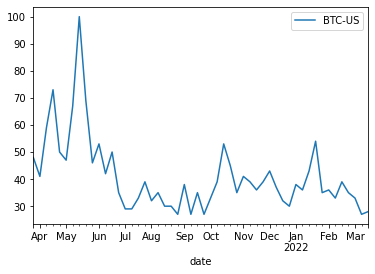

In [120]:
df_trends.plot(x='date', y='BTC-US')

In [121]:
from pytrends import dailydata

# df = dailydata.get_daily_data('cinema', 2019, 1, 2019, 10, geo = 'BR')

# print(df)

In [122]:
# df.plot(y='cinema_unscaled')

In [123]:
%%time
btc_daily_df = dailydata.get_daily_data('/m/05p0rrx', 2021, 3, 2022, 3)

btc_daily_df.head()

/m/05p0rrx:2021-03-01 2021-03-31
/m/05p0rrx:2021-04-01 2021-04-30
/m/05p0rrx:2021-05-01 2021-05-31
/m/05p0rrx:2021-06-01 2021-06-30
/m/05p0rrx:2021-07-01 2021-07-31
/m/05p0rrx:2021-08-01 2021-08-31
/m/05p0rrx:2021-09-01 2021-09-30
/m/05p0rrx:2021-10-01 2021-10-31
/m/05p0rrx:2021-11-01 2021-11-30
/m/05p0rrx:2021-12-01 2021-12-31
/m/05p0rrx:2022-01-01 2022-01-31
/m/05p0rrx:2022-02-01 2022-02-28
/m/05p0rrx:2022-03-01 2022-03-31
CPU times: user 591 ms, sys: 51.9 ms, total: 643 ms
Wall time: 1min 20s


,/m/05p0rrx_unscaled,/m/05p0rrx_monthly,isPartial,scale,/m/05p0rrx
date,,,,,
2021-03-01,100,NaN,NaN,NaN,NaN
2021-03-02,87,NaN,NaN,NaN,NaN
2021-03-03,77,NaN,NaN,NaN,NaN
2021-03-04,78,NaN,NaN,NaN,NaN
2021-03-05,72,NaN,NaN,NaN,NaN


<AxesSubplot:xlabel='date'>

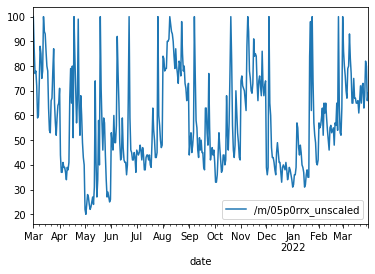

In [124]:
btc_daily_df.plot(y='/m/05p0rrx_unscaled')

<AxesSubplot:xlabel='Date'>

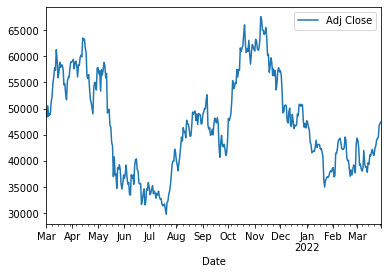

In [127]:
# display btc price history (btc_price df is declared in the cell below)

btc_price.plot(y='Adj Close')

In [126]:
# download btc price history
btc_price = yf.download('BTC-USD', 
                      start='2021-03-01', 
                      end='2022-03-29', 
                      progress=False)
# AMZN = yf.download('AMZN') for all 
btc_price = btc_price[['Adj Close','Open', 'High', 'Low', 'Close', 'Volume']].round(2)


In [130]:
#practice scaler
from sklearn.preprocessing import MinMaxScaler
trend_scaler = MinMaxScaler(feature_range=(0,1))
price_scaler = MinMaxScaler(feature_range=(0,1))

trend = btc_daily_df[btc_daily_df.columns[0]]
trend = np.array(trend)
trend = trend.reshape(-1, 1)
trend_scaled = trend_scaler.fit_transform(trend)
print(trend_scaled[:5])

close_price = btc_price[btc_price.columns[0]]
close_price = np.array(close_price)
close_price = close_price.reshape(-1, 1)
close_price_scaled = price_scaler.fit_transform(close_price)
print(close_price_scaled[:5])

trend_unscaled = trend_scaler.inverse_transform(trend_scaled)
print(trend_unscaled[:5])

close_price_unscaled = price_scaler.inverse_transform(close_price_scaled)
print(close_price_unscaled[:5])

# inputs  = sc.transform(inputs)
# rnn_predictions = sc.inverse_transform(rnn_predictions)

[[1.    ]
 [0.8375]
 [0.7125]
 [0.725 ]
 [0.65  ]]
[[0.52500432]
 [0.49184046]
 [0.54902477]
 [0.49666521]
 [0.50636158]]
[[100.]
 [ 87.]
 [ 77.]
 [ 78.]
 [ 72.]]
[[49631.24]
 [48378.99]
 [50538.24]
 [48561.17]
 [48927.3 ]]


In [146]:
# customize train-test splitter

def train_test_price_and_trend(price_df, search_df, time_steps,for_periods):
    '''
    input: 
      data: two pandas dataframes, 1. price history, 2. google search trend history
    
    output:
      X_train, y_train: first 70% of price and search data
      X_test:  final 30% of data
      sc:      insantiated MinMaxScaler object fit to the training data
    '''
    
    # isolate df columns of interest
    close_price = np.array(price_df.iloc[:,0]).reshape(-1, 1)
    search_trend = np.array(search_df.iloc[:,0]).reshape(-1, 1)


    # scale each series to itself
    from sklearn.preprocessing import MinMaxScaler
    trend_scaler = MinMaxScaler(feature_range=(0,1))
    price_scaler = MinMaxScaler(feature_range=(0,1))
    
    trend_scaled = trend_scaler.fit_transform(search_trend)
    close_price_scaled = price_scaler.fit_transform(close_price)

    # create training and test set
    split_index = int((len(trend_scaled)*.7))
    
    trend_train = trend_scaled[:split_index]
    price_train = close_price_scaled[:split_index]
    
    trend_test = trend_scaled[split_index:]
    price_test = close_price_scaled[split_index:]
    
#     # create training and test set
#     ts_train = all_data[:'2020'].iloc[:,0:1].values
#     ts_test  = all_data['2021':].iloc[:,0:1].values
#     ts_train_len = len(ts_train)
#     ts_test_len = len(ts_test)

    # create training data of s samples and t time steps (first, I'm only trying this with price history data)
    X_train_price = []
    X_train_search = []
    X_combined = []
    y_train = []
    
    for i in range(time_steps,len(trend_train)-1): 
        X_train_window = []
        
        price_window = price_train[i-time_steps:i,0]
        trend_window = trend_train[i-time_steps:i,0]
        
        for j in range(len(trend_window)):
            X_train_window.append(price_window[j])
            X_train_window.append(trend_window[j])

        X_combined.append(X_train_window)
        
#         X_train_window.append(trend_train[i-time_steps:i,0])
#         X_train_window.append(price_train[i-time_steps:i,0]) 
# #         X_combined.append(X_combined)
#         print(X_train_window)
        
        X_train_price.append(trend_train[i-time_steps:i,0])
        X_train_search.append(price_train[i-time_steps:i,0])
        
        y_train.append(trend_train[i:i+for_periods,0])
    
    X_train_price, X_train_search, y_train = np.array(X_train_price), np.array(X_train_search), np.array(y_train)
    print('X_combined: ', X_combined[:10])
    print('X_train_price[:10]: ', X_train_price[:10])
    print('X_train_search[:10]: ', X_train_search[:10])
    print('y_train[:10]: ', y_train[:10])

    # Reshaping X_train for efficient modelling
#     X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

#     inputs = pd.concat((all_data["Adj Close"][:'2020'], all_data["Adj Close"]['2021':]),axis=0).values
#     inputs = inputs[len(inputs)-len(ts_test) - time_steps:]
#     inputs = inputs.reshape(-1,1)

    # Preparing X_test
#     X_test = []
#     for i in range(time_steps,ts_test_len+time_steps-for_periods):
#         X_test.append(inputs[i-time_steps:i,0])
        
#     X_test = np.array(X_test)
#     X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

#     return X_train, y_train , X_test

# X_train, y_train, X_test = ts_train_test(all_data,5,2)
# X_train.shape[0],X_train.shape[1]

train_test_price_and_trend(btc_price, btc_daily_df, 5,3)

X_combined:  [[0.5250043167967355, 1.0, 0.4918404596673469, 0.8375000000000001, 0.5490247747055839, 0.7125, 0.4966652083132499, 0.7250000000000001, 0.5063615812505893, 0.65], [0.4918404596673469, 0.8375000000000001, 0.5490247747055839, 0.7125, 0.4966652083132499, 0.7250000000000001, 0.5063615812505893, 0.65, 0.5059664486905009, 0.48750000000000004], [0.5490247747055839, 0.7125, 0.4966652083132499, 0.7250000000000001, 0.5063615812505893, 0.65, 0.5059664486905009, 0.48750000000000004, 0.566727613833665, 0.5], [0.4966652083132499, 0.7250000000000001, 0.5063615812505893, 0.65, 0.5059664486905009, 0.48750000000000004, 0.566727613833665, 0.5, 0.5942658638307519, 0.6625000000000001], [0.5063615812505893, 0.65, 0.5059664486905009, 0.48750000000000004, 0.566727613833665, 0.5, 0.5942658638307519, 0.6625000000000001, 0.6625295157666367, 0.8500000000000001], [0.5059664486905009, 0.48750000000000004, 0.566727613833665, 0.5, 0.5942658638307519, 0.6625000000000001, 0.6625295157666367, 0.8500000000000

/var/folders/sw/bhwsqj457gg7f1ycx1_p1j480000gn/T/ipykernel_43789/3560911072.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_train_price, X_train_search, y_train = np.array(X_train_price), np.array(X_train_search), np.array(y_train)
